<a href="https://colab.research.google.com/github/jee365/ESAA/blob/main/0516_%EC%84%B8%EC%85%98_%EA%B3%BC%EC%A0%9C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **추천시스템: Model-based Collaborative Filtering**

Gradient Descent와 같은 Optimization 방법으로 parameter를 업데이트

### 1. Matrix Factorization(MF)

Matrix decompisition은 loss function과 constraints에 대한 optimization으로 여겨질 수 있다.  

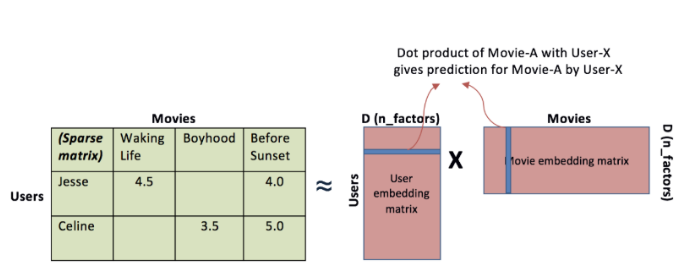




Embeddings : 아이템과 사용자의 low dimensional hidden factors

user X와 movie A에 대한 각 5개의 숫자들을 dot product를 통해 movie A가 얼마나 user X에 맞는 추천인지 알 수 있음

###2. Non-parametric approach(KNN)

memory-based 추천시스템의 아이디어와 같음, 예측을 위해 사용자 간의 또는 아이템 간의 유사성을 weights로 사용

메모리 기반 방법에서 코사인 유사도, 피어슨 유사도로 판단되는 것과 달리 Non-parametric approach에서는 unsupervised learning model을 사용

### 3. Neural Nets / Deep Learning

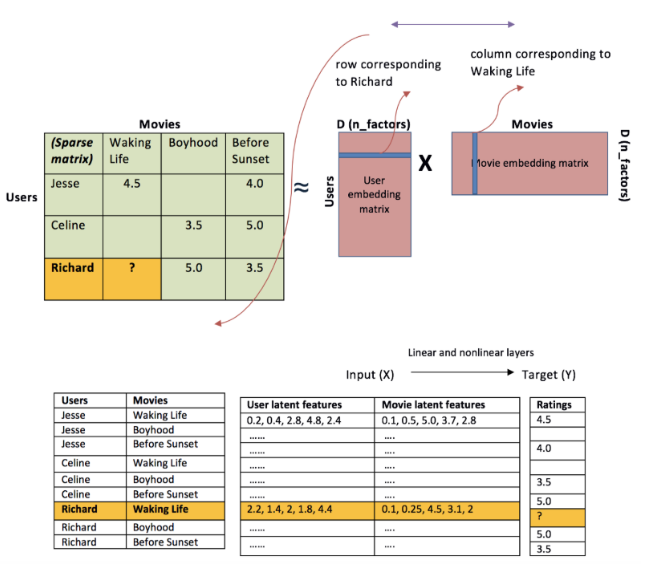

nueral nets을 이용하여 user latent features와 movie latent features를 업데이트해 최종 rating을 구하는 것이 목적(**matrix factorization**의 확장판)

꼭 두개의 low rank orthogonal matrix로 분리하지 않아도 됨

ser latent features와 Movie latent features는 linear, non-linear layers의 input -> relu, sigmoid layers에 넣어져 optimization 방법에 따른 weights를 배우게 됨

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


#### Fast.ai 패키지

1. **Shallow Learning**

In [ ]:
! pip install fastai

In [ ]:
!pip install fastcore fastai --upgrade

     |████████████████████████████████| 59 kB 4.5 MB/s 
     |████████████████████████████████| 197 kB 38.1 MB/s 
  Attempting uninstall: fastai
    Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [ ]:
import fastai
from fastai.vision import *

In [ ]:
from fastai.vision.all import *

In [ ]:
from torch.utils.data import Dataset
import os

class CollabFilterDataset(Dataset):
    def __init__(self, path, user_col, item_col, ratings):
        self.ratings,self.path = ratings.values.astype(np.float32),path
        self.n = len(ratings)
        (self.users,self.user2idx,self.user_col,self.n_users) = self.proc_col(user_col)
        (self.items,self.item2idx,self.item_col,self.n_items) = self.proc_col(item_col)
        self.min_score,self.max_score = min(ratings),max(ratings)
        self.cols = [self.user_col,self.item_col,self.ratings]

    @classmethod
    def from_data_frame(cls, path, df, user_name, item_name, rating_name):
        return cls(path, df[user_name], df[item_name], df[rating_name])

    @classmethod
    def from_csv(cls, path, csv, user_name, item_name, rating_name):
        df = pd.read_csv(os.path.join(path,csv))
        return cls.from_data_frame(path, df, user_name, item_name, rating_name)

    def proc_col(self,col):
        uniq = col.unique()
        name2idx = {o:i for i,o in enumerate(uniq)}
        return (uniq, name2idx, np.array([name2idx[x] for x in col]), len(uniq))

    def __len__(self): return self.n
    def __getitem__(self, idx): return [o[idx] for o in self.cols]

    def get_data(self, val_idxs, bs):
        val, trn = zip(*split_by_idx(val_idxs, *self.cols))
        return ColumnarModelData(self.path, PassthruDataset(*trn), PassthruDataset(*val), bs)

    def get_model(self, n_factors):
        model = EmbeddingDotBias(n_factors, self.n_users, self.n_items, self.min_score, self.max_score)
        return CollabFilterModel(to_gpu(model))

    def get_learner(self, n_factors, val_idxs, bs, **kwargs):
        return CollabFilterLearner(self.get_data(val_idxs, bs), self.get_model(n_factors), **kwargs)

In [ ]:
import torch.nn as nn

def get_emb(ni,nf):
    e = nn.Embedding(ni, nf)
    e.weight.data.uniform_(-0.05,0.05)
    return e

class EmbeddingDotBias(nn.Module):
    def __init__(self, n_factors, n_users, n_items, min_score, max_score):
        super().__init__()
        self.min_score,self.max_score = min_score,max_score
        (self.u, self.i, self.ub, self.ib) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_items, n_factors), (n_users,1), (n_items,1)
        ]]

    def forward(self, users, items):
        um = self.u(users)* self.i(items)
        res = um.sum(1) + self.ub(users).squeeze() + self.ib(items).squeeze()
        return F.sigmoid(res) * (self.max_score-self.min_score) + self.min_score

class CollabFilterLearner(Learner):
    def __init__(self, data, models, **kwargs):
        super().__init__(data, models, **kwargs)
        self.crit = F.mse_loss

class CollabFilterModel(BasicModel):
    def get_layer_groups(self): return self.model

NameError: ignored

In [ ]:
from torch import nn
class EmbeddingNet(nn.Module):
    def __init__(self, n_users, n_movies, nh=10, p1=0.05, p2=0.5):
        super().__init__()
        (self.u, self.m) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors)]]
        self.lin1 = nn.Linear(n_factors*2, nh)
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p1)
        self.drop2 = nn.Dropout(p2)
        
    def forward(self, cats, conts):
        users,movies = cats[:,0],cats[:,1]
        x = self.drop1(torch.cat([self.u(users),self.m(movies)], dim=1))
        x = self.drop2(F.relu(self.lin1(x)))
        return F.sigmoid(self.lin2(x)) * (max_rating-min_rating+1) + min_rating-0.5

In [ ]:
import numpy as np
from torch import nn
import torch.optim as optim

In [ ]:
def get_cv_idxs(n, cv_idx=0, val_pct=0.2, seed=42):
    """ Get a list of index values for Validation set from a dataset
    
    Arguments:
        n : int, Total number of elements in the data set.
        cv_idx : int, starting index [idx_start = cv_idx*int(val_pct*n)] 
        val_pct : (int, float), validation set percentage 
        seed : seed value for RandomState
        
    Returns:
        list of indexes 
    """
    np.random.seed(seed)
    n_val = int(val_pct*n)
    idx_start = cv_idx*n_val
    idxs = np.random.permutation(n)
    return idxs[idx_start:idx_start+n_val]

In [ ]:
import pandas as pd

path = '/content/gdrive/MyDrive/Colab Notebooks'
ratings = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/ratings_small.csv')

val_indx = get_cv_idxs(len(ratings))
wd = 2e-4
n_factors = 50

#data loader
cf = CollabFilterDataset.from_csv(path, 'ratings_small.csv','userId', 'movieId', 'rating')

#learner initializes model object
learn = cf.get_learner(n_factors, val_indx, bs=64, opt_fn=optim.Adam)

# fitting model with 1e-2 learning rate, 2 epochs
learn.fit(1e-2,2,wds = wd, cycle_len=1, cycle_mult=2)

NameError: ignored

2. **Deep Learning**

shallow learning에 linear, nonlinear layers를 추가함으로써 deep neural net model을 만듦

Step 1> 

In [ ]:
x = ratings.drop([‘rating’],axis=1)
y = ratings[‘rating’].astype(np.float32)
data = ColumnarModelData.from_data_frame(path, val_indx, x, y, [‘userId’, ‘movieId’], 64)

Step 2>

custom neural net을 정의

In [ ]:
# nh = dimension of hidden linear layer
# p1 = dropout1
# p2 = dropout2

class EmbeddingNet(nn.Module):
    def __init__(self, n_users, _n_movies, nh = 10, p1 = 0.05, p2= 0.5):
        super().__init__()
        (self.u, self.m, self.ub, self.mb) = [get_emb(*o) for o in [
            (n_users, n_factors), (n_movies, n_factors),
            (n_users,1), (n_movies,1)
        ]]
        
        self.lin1 = nn.Linear(n_factors*2, nh)  # bias is True by default
        self.lin2 = nn.Linear(nh, 1)
        self.drop1 = nn.Dropout(p = p1)
        self.drop2 = nn.Dropout(p = p2)
    
    def forward(self, cats, conts): # forward pass i.e.  dot product of vector from movie embedding matrixx
                                    # and vector from user embeddings matrix
        
        # torch.cat : concatenates both embedding matrix to make more columns, same rows i.e. n_factors*2, n : rows
        # u(users) is doing lookup for indexed mentioned in users
        # users has indexes to lookup in embedding matrix. 
        
        users,movies = cats[:,0],cats[:,1]
        u2,m2 = self.u(users) , self.m(movies)
       
        x = self.drop1(torch.cat([u2,m2], 1)) # drop initialized weights
        x = self.drop2(F.relu(self.lin1(x))) # drop 1st linear + nonlinear wt
        r = F.sigmoid(self.lin2(x)) * (max_rating - min_rating) + min_rating               
        return r

Step 3 >

In [ ]:
# n_users: count unique users (671), n_movies: count unique movies (9066)
model = EmbeddingNet(n_users, n_movies)

# model.parameters() for back-propagation of weights 
# lr = 1e-3, weight decay = 1e-5 and using adam optimizer 
opt = optim.Adam(model.parameters(), 1e-3, weight_decay=1e-5)

# fitting model,
fit(model, data, 3, opt, F.mse_loss)

# learning rate annealing (for more, check links at the end)
set_lrs(opt, 1e-3)
fit(model, data, 3, opt, F.mse_loss)

# Amazon Reviews를 이용한 추천시스템 실습 - surprise패키지 사용

추천시스템이 풀 수 있는 문제

1. 유저가 자신에게 아이템을 찾도록 돕는다.

2. 유저의 개입을 증가시킬 수 있다. 예를 들면, 구글 뉴스의 40퍼센트의 클릭 수 증가는 추천시스템으로 인해 발생하였다.

3. 판매자가 아이템들을 올바른 유저에게 제공하도록 한다. 

4. 컨텐츠가 더 개인화되도록 한다. 

추천시스템 유형

1. Popularity based systems :- 가장 많이 구입되거나 높게 평가된 아이템들을 추천한다. 개인화된 추천이 아니다.
2. Classification model based:- 사용자의 특성을 이해하고 분류 알고리즘을 사용하여 사용자가 특정 상품에 관심이 있는지 없는지를 결정하여 추천한다.
3. Content based recommedations:- 유저의 의견보다는 아이템 콘텐츠 정보에 기반하여 추천한다. 사용자가 아이템을 좋아하면 이와 비슷한 다른 아이템도 좋아할 거라는 의견에 기반한다.
4. Collaberative Filtering:- 유저가 좋아하는 아이템과 비슷한 아이템을 좋아하고 비슷한 취향을 가진 다른사람과 비슷한 아이템을 좋아한다는 아이디어로 추천한다. 유저-유저 추천과 아이템-아이템 추천이 있다.
5. Hybrid Approaches:- Collaborative Filtering과 content-based filtering 등을 합친 방식이다. 각 방식의 단점을 커버한다.
6. Association rule mining :- 거래의 동시 다발성 패턴을 이용하여 아이템들간의 관계를 파악한다.


<데이터 설명>
- userId : 각 유저의 고유한 아이디
- productId : 각 상품의 고유한 아이디
- Rating : 각 유저가 각 상품에 대해 평가한 평점
- timestamp : 평가 시간 (본 알고리즘에서는 무시함)

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors
# from sklearn.externals import joblib
import scipy.sparse
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
import warnings; warnings.simplefilter('ignore')
%matplotlib inline



In [ ]:
electronics_data = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/ratings_Electronics (1).csv",names=['userId', 'productId','Rating','timestamp'])

In [ ]:
electronics_data.head()

,userId,productId,Rating,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [ ]:
eletronics_data = electronics_data.iloc[:1048576,0:]

In [ ]:
eletronics_data.dtypes

userId        object
productId     object
Rating       float64
timestamp      int64
dtype: object

In [ ]:
eletronics_data.describe()['Rating'].T

count    1.048576e+06
mean     3.973380e+00
std      1.399329e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: Rating, dtype: float64

In [ ]:
print("max of rating : %d" %(eletronics_data.Rating.max()))
print("min of rating : %d" %(eletronics_data.Rating.min()))

max of rating : 5
min of rating : 1


### Missing values 수

In [ ]:
print('Number of missing values across columns: \n',electronics_data.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
Rating       0
timestamp    0
dtype: int64


### Ratings

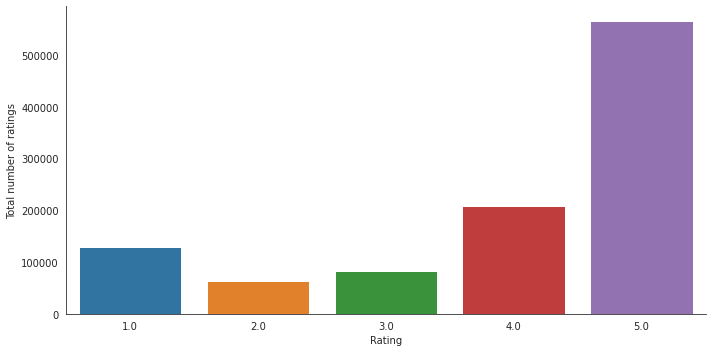

In [ ]:
with sns.axes_style('white'):
    g = sns.factorplot("Rating", data  = eletronics_data, aspect = 2.0, kind = 'count')
    g.set_ylabels("Total number of ratings")

In [ ]:
print("Total data")
print("-"*50)
print("\nTotal num of ratings :", eletronics_data.shape[0])
print("Total num of Users :", len(np.unique(eletronics_data.userId)))
print("Total num of products: ", len(np.unique(eletronics_data.productId)))

Total data
--------------------------------------------------

Total num of ratings : 1048576
Total num of Users : 786330
Total num of products:  61894


In [ ]:
eletronics_data.drop(['timestamp'],axis = 1, inplace = True)

### Ratings 분석

In [ ]:
num_of_rated_products_per_user = eletronics_data.groupby(by = 'userId')['Rating'].count().sort_values(ascending=False)
num_of_rated_products_per_user.head()

userId
A5JLAU2ARJ0BO     412
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      146
AT6CZDCP4TRGA     128
Name: Rating, dtype: int64

In [ ]:
num_of_rated_products_per_user.describe()

count    786330.000000
mean          1.333506
std           1.385612
min           1.000000
25%           1.000000
50%           1.000000
75%           1.000000
max         412.000000
Name: Rating, dtype: float64

In [ ]:
quantiles = num_of_rated_products_per_user.quantile(np.arange(0,1.01,0.01), interpolation='higher')

In [ ]:
quantiles

0.00      1
0.01      1
0.02      1
0.03      1
0.04      1
       ... 
0.96      3
0.97      4
0.98      4
0.99      6
1.00    412
Name: Rating, Length: 101, dtype: int64

<Figure size 720x720 with 0 Axes>

Text(0.5, 1.0, 'Quantiles and their Values')

Text(0, 0.5, 'No of ratings by user')

Text(0.5, 0, 'Value at the quantile')

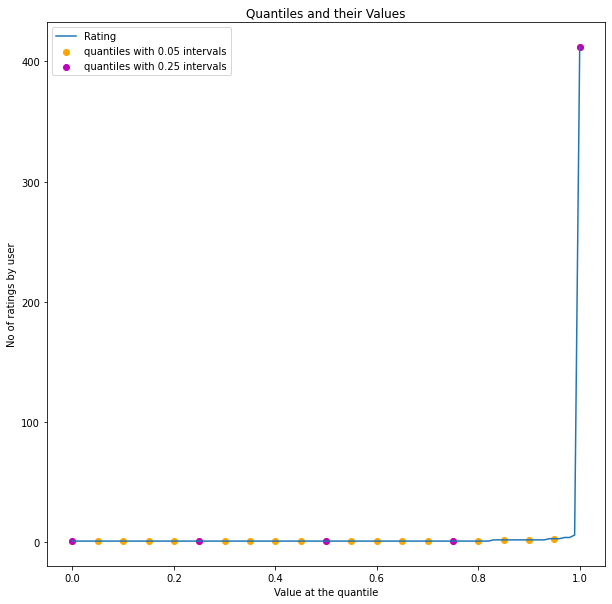

In [ ]:
plt.figure(figsize=(10,10))
plt.title("Quantiles and their Values")
quantiles.plot()
# quantiles with 0.05 difference
plt.scatter(x=quantiles.index[::5], y=quantiles.values[::5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=quantiles.index[::25], y=quantiles.values[::25], c='m', label = "quantiles with 0.25 intervals")
plt.ylabel('No of ratings by user')
plt.xlabel('Value at the quantile')
plt.legend(loc='best')
plt.show()

### Popularity Based Recommendation

In [45]:
new_df=electronics_data.groupby("productId").filter(lambda x:x['Rating'].count() >=50)

In [46]:
new_df.head()

,userId,productId,Rating,timestamp
183,A1BKC6B7YHYTVV,0972683275,4.0,1405382400
184,AWVFSIB42LHKJ,0972683275,4.0,1405209600
185,A36MQBNADRH8YY,0972683275,5.0,1405641600
186,A3SRXMPLAEZ6DP,0972683275,4.0,1405987200
187,A20XXTXWF2TCPY,0972683275,5.0,1405123200


In [47]:
new_df.shape

(5374313, 4)

Text(0.5, 1.0, '# RATINGS per Product')

Text(0.5, 0, 'Product')

Text(0, 0.5, 'No of ratings per product')

[]

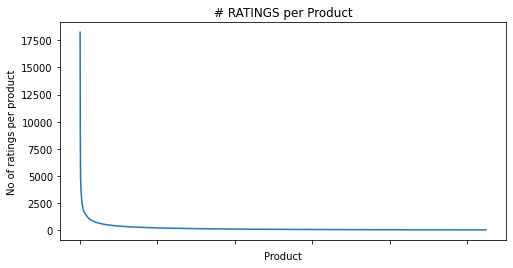

In [48]:
num_of_ratings_per_product = new_df.groupby(by='productId')['Rating'].count().sort_values(ascending=False)

fig = plt.figure(figsize=plt.figaspect(.5))
ax = plt.gca()
plt.plot(num_of_ratings_per_product.values)
plt.title('# RATINGS per Product')
plt.xlabel('Product')
plt.ylabel('No of ratings per product')
ax.set_xticklabels([])

plt.show()

In [49]:
new_df.groupby('productId')['Rating'].mean().head()

productId
0972683275    4.470980
1400501466    3.560000
1400501520    4.243902
1400501776    3.884892
1400532620    3.684211
Name: Rating, dtype: float64

In [50]:
new_df.groupby('productId')['Rating'].mean().sort_values(ascending=False).head()

productId
B002E6R7NG    4.980392
B004I763AW    4.966667
B003J9QQWU    4.964286
B0043ZLFXE    4.955556
B000TMFYBO    4.953125
Name: Rating, dtype: float64

In [51]:
new_df.groupby('productId')['Rating'].count().sort_values(ascending=False).head()

productId
B0074BW614    18244
B00DR0PDNE    16454
B007WTAJTO    14172
B0019EHU8G    12285
B006GWO5WK    12226
Name: Rating, dtype: int64

In [52]:
ratings_mean_count = pd.DataFrame(new_df.groupby('productId')['Rating'].mean())

In [53]:
ratings_mean_count.head()

,Rating
productId,
0972683275,4.470980
1400501466,3.560000
1400501520,4.243902
1400501776,3.884892
1400532620,3.684211


In [54]:
ratings_mean_count['rating_counts'] = pd.DataFrame(new_df.groupby('productId')['Rating'].count())

In [55]:
ratings_mean_count.head()

,Rating,rating_counts
productId,,
0972683275,4.470980,1051
1400501466,3.560000,250
1400501520,4.243902,82
1400501776,3.884892,139
1400532620,3.684211,171


In [56]:
ratings_mean_count['rating_counts'].max()

18244

<Figure size 432x432 with 0 Axes>

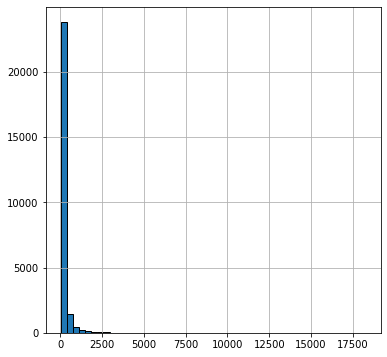

In [57]:
plt.figure(figsize=(6,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['rating_counts'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

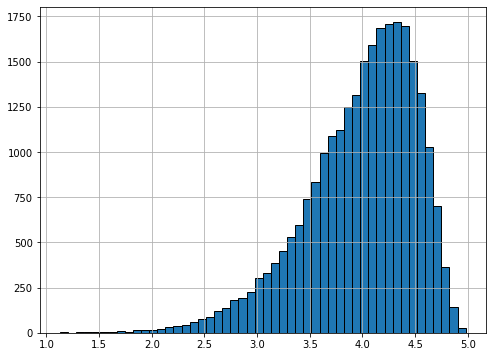

In [58]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor']=True
ratings_mean_count['Rating'].hist(bins=50)

<Figure size 576x432 with 0 Axes>

<Figure size 576x432 with 0 Axes>

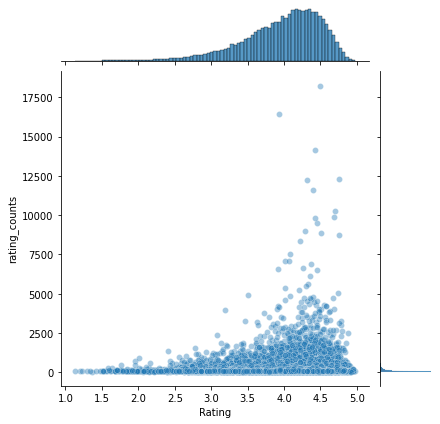

In [59]:
plt.figure(figsize=(8,6))
plt.rcParams['patch.force_edgecolor'] = True
sns.jointplot(x='Rating', y='rating_counts', data=ratings_mean_count, alpha=0.4)

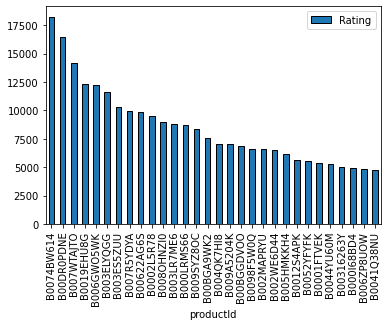

In [60]:
popular_products = pd.DataFrame(new_df.groupby('productId')['Rating'].count())
most_popular = popular_products.sort_values("Rating", ascending=False)
most_popular.head(30).plot(kind = "bar")